In [1]:
# monter le google drive pour qu'il soit accessible ("Fichiers" dans colab - liste à gauche)

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# installation des librairies pas implémentées par défaut
%pip install optuna
%pip install shap
%pip install tpot

In [9]:
# Importation des librairies nécessaires

import optuna
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    recall_score,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay,
)
from imblearn.metrics import classification_report_imbalanced
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
import xgboost as xgb
from tpot import TPOTClassifier


from joblib import dump, load


# Option à modifier pour visualiser la totalité des colonnes

pd.set_option("display.max_columns", None)

In [10]:
def Create_Index(df):
    # paramètres généraux
    tts_test_size = 0.2    # définir la proportion du nombre d'incidents à affecter au jeu de test
    np.random.seed(42)     # fixer le caractère aléatoire (même base + même seed => donnera la même liste)
    # Faire la liste des incidents et la trier
    tts_inc_list = df['IncidentNumber'].unique().tolist()
    tts_inc_list.sort()
    # Total des véhicules et incidents pour juger de la répartition train / test
    tts_nb_pump = df.shape[0]
    tts_nb_inc = len(tts_inc_list)
    # Taille de la liste des incidents à mettre en jeu de test
    tts_test_size_nb = np.int64(tts_nb_inc * tts_test_size)
    # liste des n° d'incidents à garder dans le jeu de test = sélectionner 'test_size_nb' éléments de la liste, par un tirage sans remise
    tts_inc_test_list = list(np.random.choice(tts_inc_list, tts_test_size_nb, replace= False))
    # sauvegarder les index des lignes des incidents que l'on affectera en test et train
    # car nous allons ensuite supprimer la variable 'IncidentNumber'
    tts_index_test = df[df['IncidentNumber'].isin(tts_inc_test_list)].index
    tts_index_train = df[~df['IncidentNumber'].isin(tts_inc_test_list)].index
    return tts_index_test,tts_index_train

# fonction créant la variable binaire cible
def Create_Goal(df):
    conditions = [
        (df["AttendanceTimeSeconds"] > 360),
        (df["AttendanceTimeSeconds"] <= 360),
    ]
    choices = [1, 0]
    df["Goal"] = np.select(conditions, choices)

def To_num(df):
    df.workingday=df.workingday.astype('int64')
    df.school_holidays=df.school_holidays.astype('int64')
    return df

# fonction selectionnant les features et la target dans le dataframe
def Select_Column(df):
    return df[
        [
         'DeployedFromLocation',
         'Appliance',
         'PropertyCategory',
         'AddressQualifier',
         'IncidentType',
         'Distance',
         'TotalOfPumpInLondon_Out',
         'Station_Code_of_ressource',
         'IncidentStationGround_Code',
         'PumpAvailable',
         'month',
         'temp',
         'precip',
         'cloudcover',
         'visibility',
         'conditions',
         'workingday',
         'school_holidays',
         'congestion_rate',
         'Goal',
            
        ]
    ]


# fonction dicotomisant les features de type object
def Object_dummies(df):
    return df.select_dtypes(exclude="object").join(
        pd.get_dummies(df.select_dtypes("object"))
    )


# fonction dicotomisant PumpAvaillable, variable numérique catégorielle
def PumpAvailable_Dummies(df):
    for i in ["PumpAvailable"]:
        dummy3 = pd.get_dummies(df[i], prefix=i)
        df = pd.concat([df, dummy3], axis=1)
        df.drop(["PumpAvailable"], 1, inplace=True)
        return df


# fonction centré réduire les variables numériques non catégorielles
def StandardSC(df):
    sc = StandardScaler()
    df[
        [
            "Distance",
            "congestion_rate",
            "TotalOfPumpInLondon_Out",
            "temp",
            "precip",
            "cloudcover",
            "visibility",
        ]
    ] = sc.fit_transform(
        df[
            [
                "Distance",
                "congestion_rate",
                "TotalOfPumpInLondon_Out",
                "temp",
                "precip",
                "cloudcover",
                "visibility",
            ]
        ]
    )
    return df


# fonction regroupant les différentes étapes précédentes
def Traitement(df):
    Create_Goal(df)
    df = Select_Column(df)
    df = To_num(df)
    df = Object_dummies(df)
    df = PumpAvailable_Dummies(df)
    df = StandardSC(df)
    return df


# fonction de séparation en jeu d'apprentissage (train) et jeu de test
def Train_Test(df):
    data = df.drop("Goal", 1)
    target = df["Goal"]
    X_train = data.loc[tts_index_train]
    X_test = data.loc[tts_index_test]
    y_train = target.loc[tts_index_train]
    y_test = target.loc[tts_index_test]
    return X_train, X_test, y_train, y_test


# fonction calculant la cross validation sur le jeu d'apprentissage puis ajustement du modèle sur le jeu d'apprentissage et application sur le jeu de test
def Cross(model, scoring):
    cross = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
    print("\n Résultat de la Cross Validation:")
    print(cross)
    print(cross.mean())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(" \n Matrice de confusion:")
    print(pd.crosstab(y_test, y_pred))
    print("\n Rapport des résultats de classifcation:")
    print(classification_report_imbalanced(y_test, y_pred))
    return model, y_pred


# fonction affichant les features les plus significatives
def plot_bar(model):
    tt = pd.DataFrame(model.coef_.T)
    tt.rename(columns={0: "coeff"}, inplace=True)
    tt.index = X_train.columns
    print(tt.sort_values(by="coeff", ascending=False, key=abs).head(10))
    print("\n")
    tt.sort_values(by="coeff", ascending=False, key=abs).head(20).plot(
        kind="barh", figsize=(10, 10)
    );

In [11]:
df = pd.read_pickle(
    "/content/drive/MyDrive/Projet Pompier/Github/structure_finale/data_outputs/base_ml.pkl"
)

In [12]:
tts_index_test,tts_index_train=Create_Index(df)

In [13]:
df = Traitement(df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
# Création jeu d'apprentissage et de test

In [ ]:
X_train, X_test, y_train, y_test = Train_Test(df)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
def objective(trial):

    params = {
        "alpha": trial.suggest_loguniform("alpha", 0.0001, 0.01),
        "loss": trial.suggest_categorical("loss", ["hinge", "modified_huber"]),
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
    }
    model1 = SGDClassifier(**params, class_weight="balanced", random_state=42)
    model1.fit(X_train, y_train)
    y_pred = model1.predict(X_test)
    score = recall_score(y_test, y_pred)

    return score


study = optuna.create_study(
    direction="maximize", study_name="sgdc", pruner=optuna.pruners.HyperbandPruner()
)
study.optimize(objective, n_trials=50)
print("numbers of the finished trials:", len(study.trials))
print("the best params:", study.best_trial.params)
print("the best value:", study.best_value)

In [ ]:
params={'alpha': 0.0010782085713272802, 'loss': 'modified_huber', 'penalty': 'l2'}

In [ ]:
sgd_optuna = SGDClassifier(
    **params, class_weight="balanced", random_state=42
)
Cross(sgd_optuna, "recall")


 Résultat de la Cross Validation:
[0.79859097 0.74681783 0.76827897 0.71496655 0.76528921]
0.7587887040435735
 
 Matrice de confusion:
col_0      0      1
Goal               
0      51440  15630
1       8728  33701

 Rapport des résultats de classifcation:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.77      0.79      0.81      0.78      0.61     67070
          1       0.68      0.79      0.77      0.73      0.78      0.61     42429

avg / total       0.79      0.78      0.78      0.78      0.78      0.61    109499



(SGDClassifier(alpha=0.0011426952084614796, class_weight='balanced',
               loss='modified_huber', random_state=42),
 array([0, 0, 0, ..., 1, 1, 1]))

In [ ]:
y_pred=sgd_optuna.predict(X_test)
y_test_pred=pd.Series(y_pred,index=y_test.index)

In [ ]:
#sauvegarde de y_test_pred contenant les predictions de y_test pour comparaison avec le modèle de régression
y_test_pred.to_pickle('/content/drive/MyDrive/Projet Pompier/Github/structure_finale/data_outputs/ml_target_360/y_pred.pkl')

                                                 coeff
Distance                                      0.758188
AddressQualifier_On motorway / elevated road  0.296856
Station_Code_of_ressource_G29                 0.251262
Station_Code_of_ressource_H33                -0.244502
Station_Code_of_ressource_F38                -0.237082
IncidentStationGround_Code_H41               -0.229104
Station_Code_of_ressource_G39                -0.219636
Station_Code_of_ressource_A36                -0.211512
IncidentStationGround_Code_A24                0.210518
Station_Code_of_ressource_H24                -0.202842




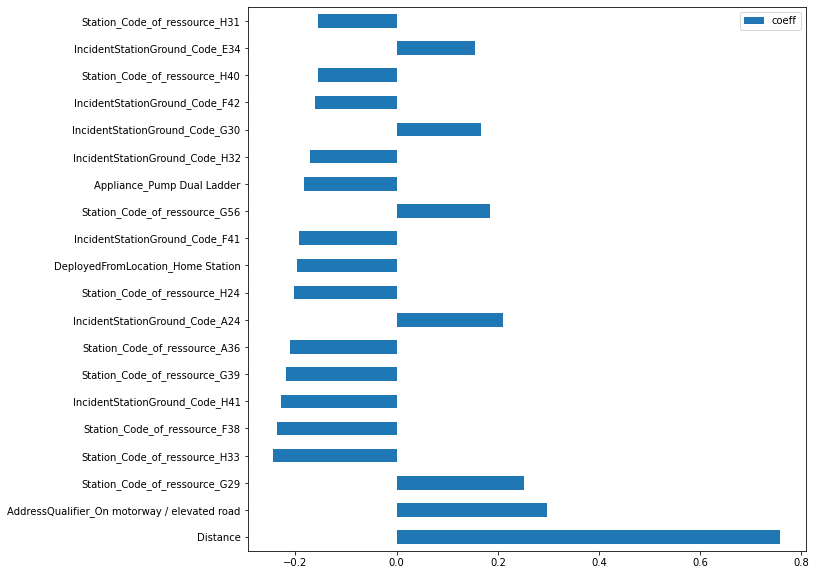

In [ ]:
#graphique des features selon leurs importances (filtre sur les 10 plus significatives)
plot_bar(sgd_optuna)

In [ ]:
explainer = shap.LinearExplainer(sgd_optuna, X_train)
shap_values = explainer.shap_values(X_test)
preds = sgd_optuna.predict(X_test)

In [ ]:
print("Test data (actual observation): {}".format(y_test.iloc[1]))
print("Model's prediction: {}".format(preds[1]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1, :], X_test.iloc[1, :])

Test data (actual observation): 0
Model's prediction: 0


In [ ]:
print("Test data (actual observation): {}".format(y_test.iloc[54789]))
print("Model's prediction: {}".format(preds[54789]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[5478, :], X_test.iloc[54787, :])

Test data (actual observation): 0
Model's prediction: 0


In [ ]:
print("Test data (actual observation): {}".format(y_test.iloc[54784]))
print("Model's prediction: {}".format(preds[54784]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[54784, :], X_test.iloc[54784, :])

Test data (actual observation): 1
Model's prediction: 1


In [ ]:
print("Test data (actual observation): {}".format(y_test.iloc[5000]))
print("Model's prediction: {}".format(preds[5000]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[5000, :], X_test.iloc[5000, :])

Test data (actual observation): 1
Model's prediction: 0


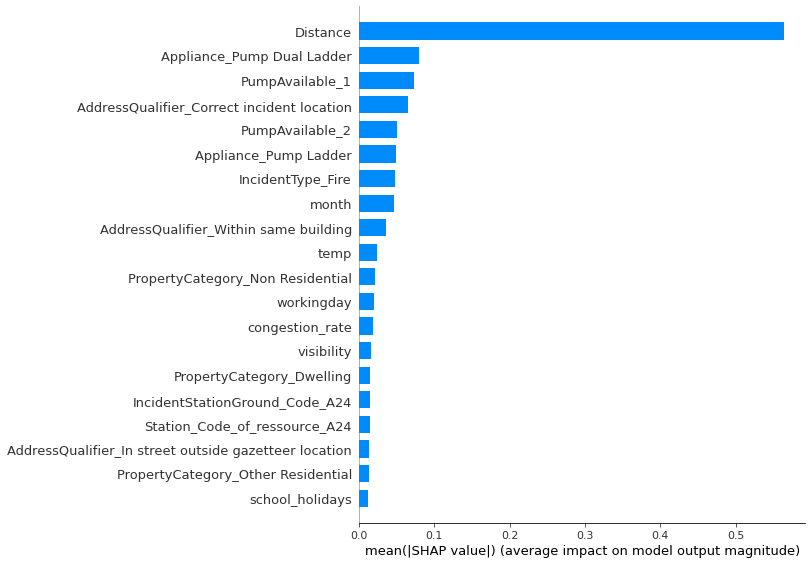

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

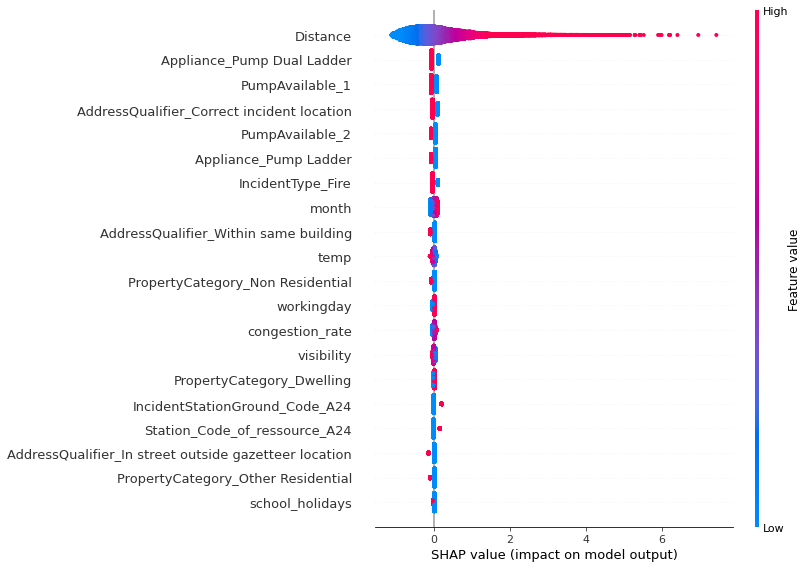

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, X_test)